In [1]:
import sys
sys.path.append('../reconstruct_missing_data')

from data_loading import find_data_files, load_data_set, get_anomalies, create_missing_mask, split_and_scale_data, eof_weights, get_land_silhouette

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
from pathlib import Path
from json import dump, load
import os

In [2]:
# Check current working directory:
print(os.getcwd())

/gxfs_work1/geomar/smomw511/GitHub/MarcoLandtHayen/reconstruct_missing_data/notebooks


In [3]:
## Load CESM and FOCI data, including ALL features and mask for Ocean values:

# Specify path to data: Test data of full data.
# data_path='../data/test_data/'
data_path='../../../../climate_index_collection/data/raw/2022-08-22/'

# Select data source: 'FOCI' or 'CESM':
data_source_name='CESM'

# Load data:
data = load_data_set(data_path=data_path, data_source_name=data_source_name)

In [4]:
## Extract raw data for single feature:

# Specify feature to select:
feature = 'sea-level-pressure'

# Extract feature:
feature_raw = data['sea-level-pressure']

In [5]:
# For equidistant latitude/longitude grids the area weights are proportional to cos(lat).
# Before applying Singular Value Decomposition, input data is multiplied with the square root of the weights.
feature_weighted = feature_raw * eof_weights(feature_raw)

In [6]:
# Remove seasonal cycle to get anomalies, use whole time span as climatology:
climatology = feature_weighted.groupby("time.month").mean("time")
feature_anomaly = (feature_weighted.groupby("time.month") - climatology).drop("month")

In [7]:
# Flatten spatial dimensions:
feature_anomaly_flat = feature_anomaly.stack(tmp_space=("lat", "lon")).dropna(dim="tmp_space")

In [8]:
# Perform SVD on flat feature anomaly, after removing mean over time:
pc, s, eof = sp.linalg.svd(
    feature_anomaly_flat - feature_anomaly_flat.mean(axis=0), full_matrices=False
)

print("pc shape: ", pc.shape)
print("s shape: ", s.shape)
print("eof shape: ", eof.shape)

pc shape:  (11988, 11988)
s shape:  (11988,)
eof shape:  (11988, 13824)


In [9]:
# Compute explained variance from singular values:
exp_var = s**2 / (s**2).sum()

## Get accumulated explained variance:

# Initialize storage:
exp_var_acc = np.zeros(exp_var.shape)

# Run over array of explained variance:
for i in range(len(exp_var)):
    
    # First step to initialize accumulated variance:
    if i == 0:
        exp_var_acc[i] = exp_var[i]
    else:
        exp_var_acc[i] = exp_var_acc[i-1] + exp_var[i]

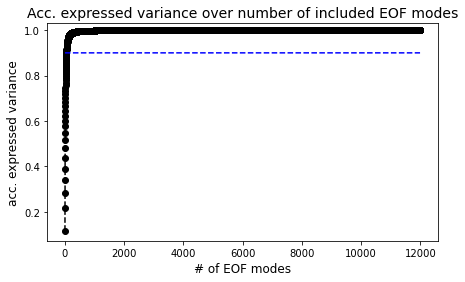

In [12]:
# Plot accumulated expressed variance over EOF modes.
fig, axes = plt.subplots(1,1,figsize=(7,4))

axes.plot(np.arange(0,len(exp_var_acc),step=1)+1, exp_var_acc, color='black', marker='o', linestyle='--')
# Optionally add threshold:
axes.plot(np.arange(0,len(exp_var_acc),step=1)+1, np.ones(len(exp_var_acc))*0.9, color='blue', linestyle='--')

axes.set_ylim(top=1.03)
axes.set_title('Acc. expressed variance over number of included EOF modes', fontsize=14)
axes.set_xlabel('# of EOF modes', fontsize=12)
axes.set_ylabel('acc. expressed variance', fontsize=12)
#axes.legend()
plt.show() 

In [95]:
# Look for how many EOFs we need to include, to exceed 90% of total explained variance:
exp_var_acc[:50]

array([0.11600983, 0.21804424, 0.2820242 , 0.34039389, 0.38941953,
       0.43491928, 0.48032525, 0.51532491, 0.54833003, 0.57570611,
       0.60018331, 0.62339132, 0.64575815, 0.66545187, 0.68436179,
       0.70283824, 0.71800806, 0.73252271, 0.74533508, 0.75734046,
       0.76925629, 0.78038733, 0.78972798, 0.79874329, 0.80677167,
       0.81448862, 0.82148235, 0.82794592, 0.83405512, 0.83958679,
       0.84492904, 0.84991984, 0.85465526, 0.85918665, 0.86330618,
       0.86726234, 0.87111352, 0.87479393, 0.878299  , 0.88169085,
       0.88497131, 0.88797662, 0.89075333, 0.89347802, 0.89607057,
       0.89855943, 0.90098775, 0.90329873, 0.90558334, 0.90775113])

In [13]:
# Postprocess pc time series: Divide by its standard deviation.
pc_std = pc.std(axis=0)
pc /= pc_std

# Put to xarray, define 'mode' index:
mode = np.arange(1, len(pc_std) + 1)
pc = pc.T
pc = xr.DataArray(
    pc,
    dims=('mode', 'time'),
    coords={'mode': mode, 'time': feature_anomaly_flat['time']}
)

In [14]:
# Postprocess eofs:
eof *= pc_std[:, np.newaxis]
eof *= s[:, np.newaxis]

eofs = feature_anomaly_flat.copy()
eofs[:, eofs[0].notnull().values] = eof
eofs = eofs.unstack(dim='tmp_space').rename(**{'time': 'mode'})
eofs.coords['mode'] = mode

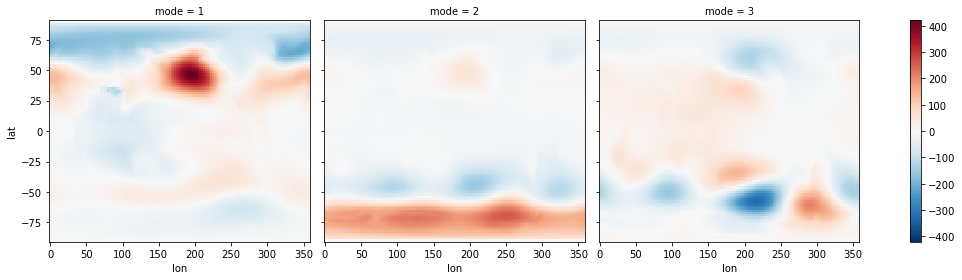

In [98]:
eofs.sel(mode=slice(1, 3)).plot(col='mode', figsize=(15, 4), rasterized=True);

In [115]:
# Get land silhouette:
land_silhouette = get_land_silhouette(data_path="../data/test_data/", data_source_name="CESM")

In [121]:
# Copy first 3 EOF modes and superimpose silhouette, highlighting continents' shape:
eofs_silhouette = np.copy(eofs[:3].values)
eofs_silhouette[:,land_silhouette] = float('nan')

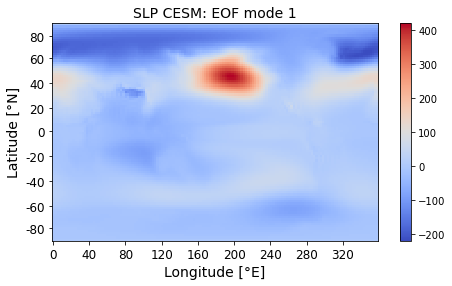

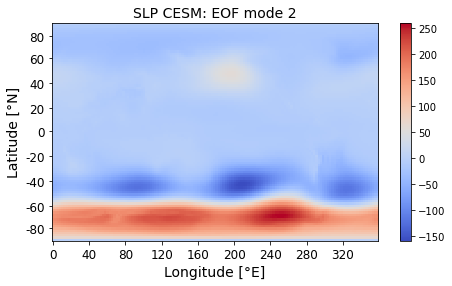

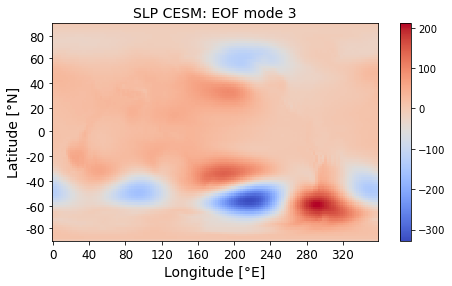

In [15]:
## Plot first 3 EOF modes as heatmap (without land silhouette):  

# Plot:
for i in range(3):
    
    fig, ax = plt.subplots(figsize=(8, 4))
    im = plt.imshow(np.flip(eofs.values[i],axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('', fontsize=14)
    plt.title('SLP CESM: EOF mode '+str(i+1), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

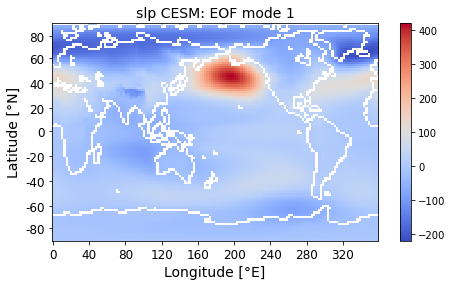

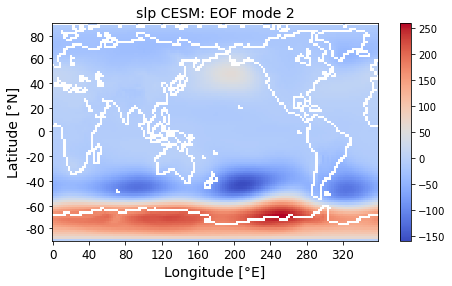

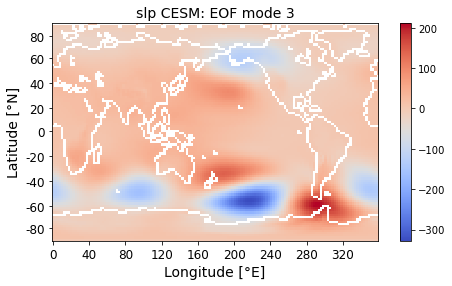

In [126]:
## Plot first 3 EOF modes as heatmap (with land silhouette):  

# Plot:
for i in range(3):
    
    fig, ax = plt.subplots(figsize=(8,4 ))
    im = plt.imshow(np.flip(eofs_silhouette[i],axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('', fontsize=14)
    plt.title('slp CESM: EOF mode '+str(i+1), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

In [75]:
## Reload optimal fixed masks from relevance experiments:

# Set paths to optimal missing masks as strings:
paths_to_missing_masks_string = [
    '../../../../GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final/relevance_exp_12',
    '../../../../GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final/relevance_exp_13',
]

# Load masks:
optimal_sampling_mask_999 = np.load(Path(paths_to_missing_masks_string[0]) / "optimal_sampling_mask_999.npy")
optimal_sampling_mask_99 = np.load(Path(paths_to_missing_masks_string[1]) / "optimal_sampling_mask_99.npy")

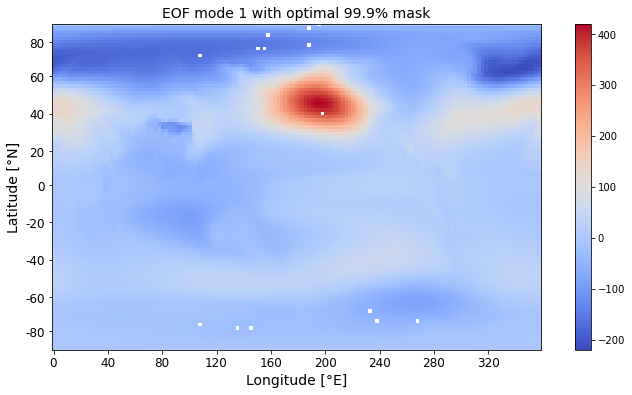

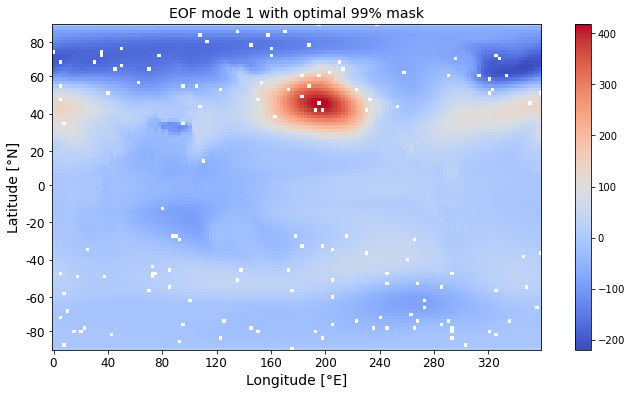

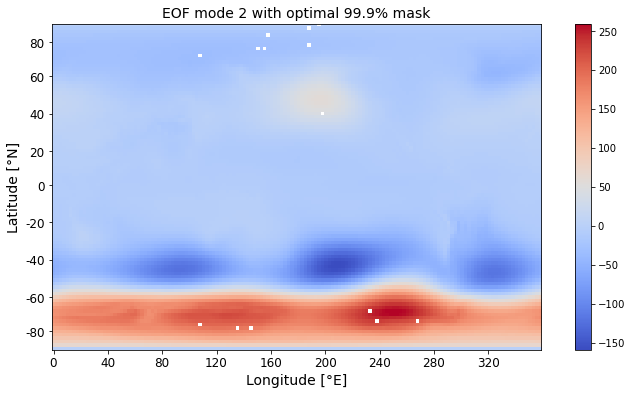

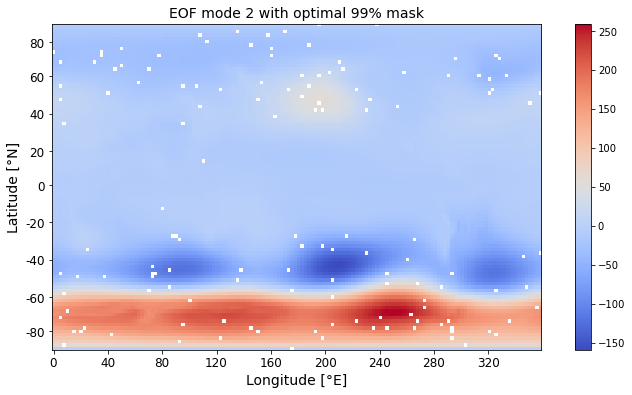

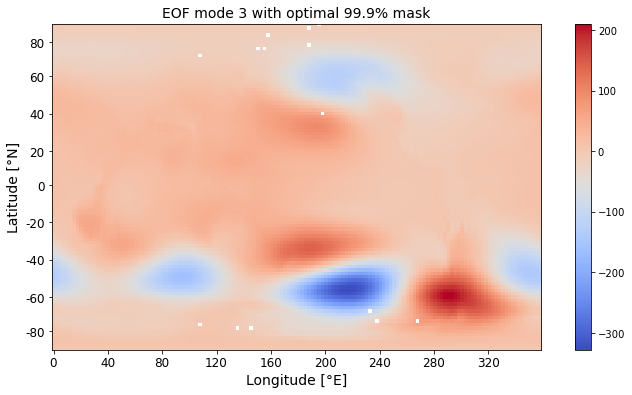

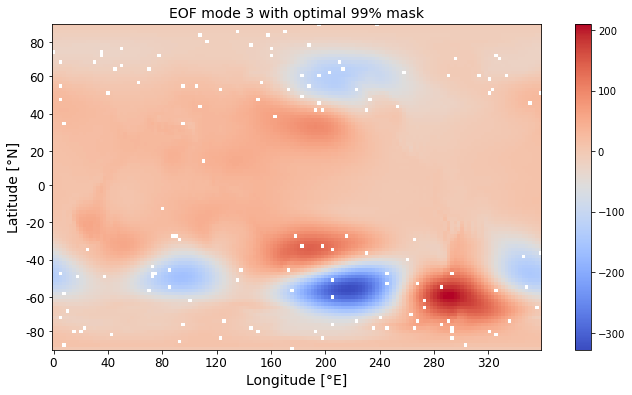

In [99]:
## Plot first EOF modes including optimal grid points from fixed mask as NaN values (=white dots).

# Extract EOF modes as numpy array:
eof_1_with_mask_999 = np.copy(eofs.values[0])
eof_1_with_mask_99 = np.copy(eofs.values[0])
eof_2_with_mask_999 = np.copy(eofs.values[1])
eof_2_with_mask_99 = np.copy(eofs.values[1])
eof_3_with_mask_999 = np.copy(eofs.values[2])
eof_3_with_mask_99 = np.copy(eofs.values[2])

# Set grid points from optimal mask to NaN:
eof_1_with_mask_999[optimal_sampling_mask_999] = float('nan')
eof_1_with_mask_99[optimal_sampling_mask_99] = float('nan')
eof_2_with_mask_999[optimal_sampling_mask_999] = float('nan')
eof_2_with_mask_99[optimal_sampling_mask_99] = float('nan')
eof_3_with_mask_999[optimal_sampling_mask_999] = float('nan')
eof_3_with_mask_99[optimal_sampling_mask_99] = float('nan')

# Plot first EOF mode including mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(eof_1_with_mask_999,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('EOF mode 1 with optimal 99.9% mask', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot first EOF mode including mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(eof_1_with_mask_99,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('EOF mode 1 with optimal 99% mask', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot first EOF mode including mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(eof_2_with_mask_999,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('EOF mode 2 with optimal 99.9% mask', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot first EOF mode including mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(eof_2_with_mask_99,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('EOF mode 2 with optimal 99% mask', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot first EOF mode including mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(eof_3_with_mask_999,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('EOF mode 3 with optimal 99.9% mask', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot first EOF mode including mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(eof_3_with_mask_99,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('EOF mode 3 with optimal 99% mask', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [110]:
land_silhouette = get_land_silhouette(data_path="../data/test_data/", data_source_name="FOCI")

/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [22]:
# Extract single field, here: Sea surface temperature
sst_FOCI = data_FOCI['sea-surface-temperature'].values
sst_FOCI.shape

(120, 96, 192)

In [7]:
np.sum(np.isnan(sst_CESM))

665760

In [23]:
# Extract ocean mask:
is_over_ocean_CESM = data_CESM['is_over_ocean'].values
is_over_ocean_CESM.shape

(96, 144)

In [25]:
# Extract ocean mask:
is_over_ocean_FOCI = data_FOCI['is_over_ocean'].values
is_over_ocean_FOCI.shape

(96, 192)

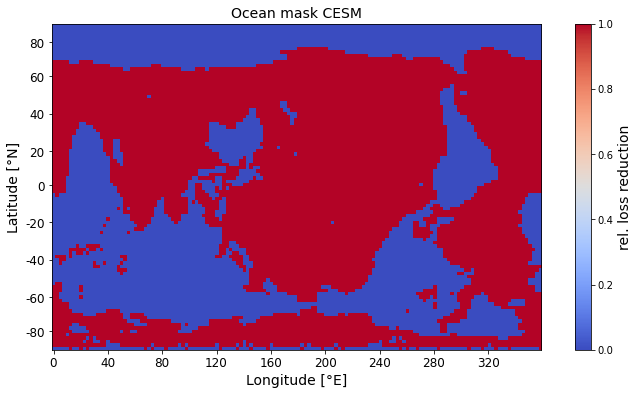

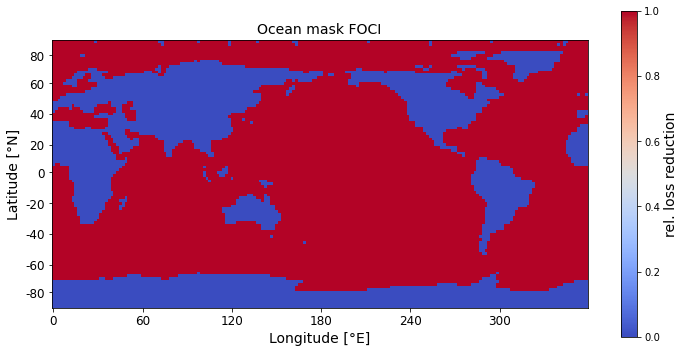

In [27]:
# Plot resulting ocean mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(is_over_ocean_CESM, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Ocean mask CESM', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot resulting ocean mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(is_over_ocean_FOCI, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Ocean mask FOCI', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

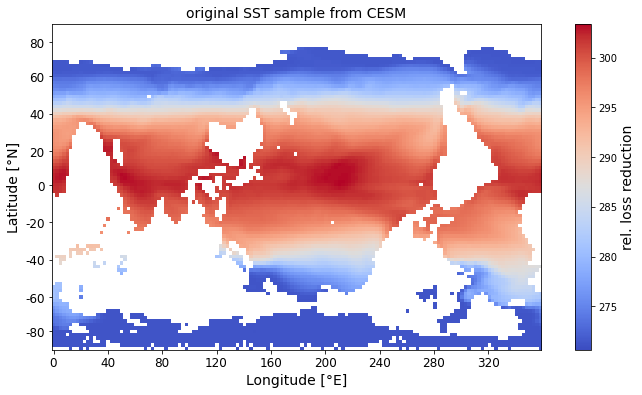

In [33]:
# Plot first SST sample from CESM test data:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(sst_CESM[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('original SST sample from CESM', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

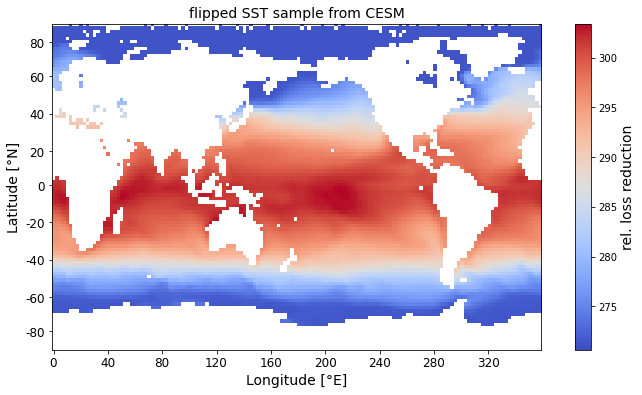

In [32]:
# Plot first SST sample from CESM test data:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(sst_CESM[0], axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('flipped SST sample from CESM', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [62]:
## Derive mask for showing only the continents' silhouette as NaN values, for better orientation in slp fields.

# Initialize storage for silhouette as boolean mask:
land_silhouette_CESM = (np.zeros(is_over_ocean_CESM.shape)!=0)

# Loop over latitude in ocean mask, to scan mask line-by-line:
for i in range(is_over_ocean_CESM.shape[0]):
    
    # Loop over longitude, to scan current line:
    for j in range(is_over_ocean_CESM.shape[1]):
        
        # Check, if current grid point is over land, while previous grid point was over ocean.
        # Take care of initial border:
        if j>0:
            if (is_over_ocean_CESM[i,j]==False) & (is_over_ocean_CESM[i,j-1]==True):
                
                # Set land silhouette:
                land_silhouette_CESM[i,j] = True
                
        # Check, if current grid point is over ocean, while previous grid point was over land.
        # Take care of initial border:
        if j>0:
            if (is_over_ocean_CESM[i,j]==True) & (is_over_ocean_CESM[i,j-1]==False):
                
                # Set land silhouette:
                land_silhouette_CESM[i,j] = True
                
# Loop over longitude in ocean mask, to scan mask row-by-row:
for j in range(is_over_ocean_CESM.shape[1]):
    
    # Loop over latitude, to scan current row:
    for i in range(is_over_ocean_CESM.shape[0]):
        
        # Check, if current grid point is over land, while previous grid point was over ocean.
        # Take care of initial border:
        if i>0:
            if (is_over_ocean_CESM[i,j]==False) & (is_over_ocean_CESM[i-1,j]==True):
                
                # Set land silhouette:
                land_silhouette_CESM[i,j] = True
                
        # Check, if current grid point is over ocean, while previous grid point was over land.
        # Take care of initial border:
        if i>0:
            if (is_over_ocean_CESM[i,j]==True) & (is_over_ocean_CESM[i-1,j]==False):
                
                # Set land silhouette:
                land_silhouette_CESM[i,j] = True
            

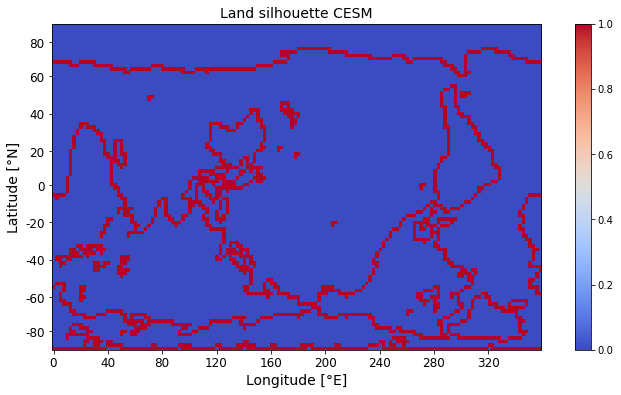

In [69]:
# Plot resulting land silhouette as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(land_silhouette_CESM, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Land silhouette CESM', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [70]:
# Select single feature and compute anomalies, using whole time span as climatology:
data = get_anomalies(feature='sea-level-pressure', data_set=data_CESM) 

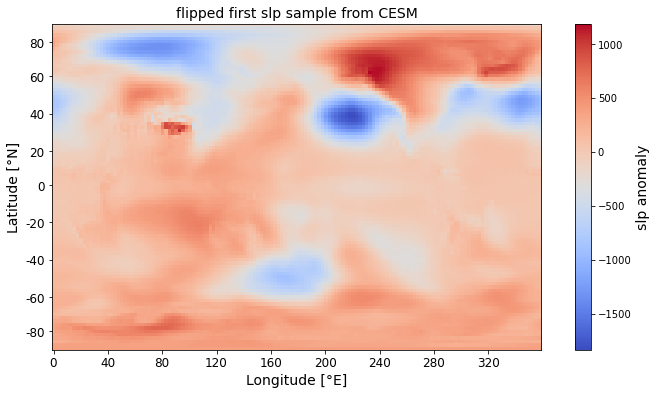

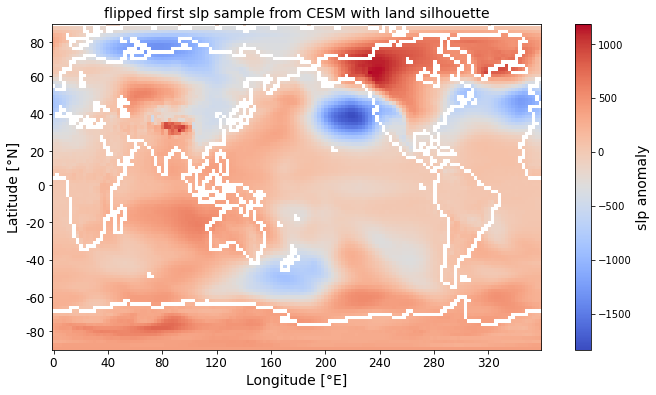

In [71]:
# Extract first sample:
temp_sample = data[0]

# Plot flipped original sample:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(temp_sample,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('slp anomaly', fontsize=14)
plt.title('flipped first slp sample from CESM', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Add land silhouette as NaN values:
temp_sample[land_silhouette_CESM]=float('nan')

# Plot flipped sample with land silhouette:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(temp_sample,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('slp anomaly', fontsize=14)
plt.title('flipped first slp sample from CESM with land silhouette', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [11]:
missing_mask = create_missing_mask(data=data, mask_type='fixed', missing_type='discrete', missing_min=0.9, missing_max=0.9, seed=0)

In [23]:
np.sum(np.isnan(data))

0

In [13]:
np.sum(missing_mask,axis=(1,2))

array([1835, 1835, 1835, ..., 1835, 1835, 1835])

In [14]:
# Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
# Scale or normlalize data according to statistics obtained from only training data.
train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
    data, 
    missing_mask, 
    train_val_split=0.8, 
    scale_to='zero_one'
)

In [24]:
temp_number = np.sum(train_target==0) + np.sum(val_target==0)

In [19]:
np.size(data)*0.9

199065600.0

In [20]:
(np.sum(train_input==0) + np.sum(val_input==0)) - (np.size(data)*0.9)

6734400.0

In [26]:
(np.sum(train_input!=0) + np.sum(val_input!=0)) 

15384000

In [27]:
(np.size(data) - temp_number)*0.1

15538799.9

In [76]:
np.sum(np.isnan(data))

65796000

In [69]:
data[np.isnan(data)]=0

In [71]:
np.max(data)

13.437347

In [ ]:
   

# Extend data, if desired:
data = clone_data(data=data, augmentation_factor=augmentation_factor)

In [ ]:
sst_FOCI[!] = 0

In [36]:
ocean = np.repeat(np.expand_dims(is_over_ocean,axis=0),sst_FOCI.shape[0],axis=0)

In [37]:
sst_FOCI[(ocean==False)]=0

In [38]:
np.sum(np.isnan(sst_FOCI))

0

In [35]:
ocean

(12000, 96, 192)

In [55]:
np.sum(np.isnan(data_FOCI['sea-surface-temperature'].where(data_FOCI["is_over_ocean"]).values))

65796000

In [51]:
np.random.seed(0)
np.random.uniform(low=0, high=1, size=(2,3))

array([[0.5488135 , 0.71518937, 0.60276338],
       [0.54488318, 0.4236548 , 0.64589411]])